In [80]:
import pandas as pd
import numpy as np
import optuna
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,precision_recall_curve

In [72]:
df = pd.read_csv('datasets/dataset_complication_prediction.csv')
df = df.drop('race', axis=1) # remove 'race' for ethical reason (we checked that the feature was also uncorelated)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # to shuffle the dataset
df_sample = df.iloc[:5]
df_sample_no_complication = df_sample.drop('complication', axis=1)
df_sample_no_complication.to_csv('samples/sample_complication_prediction.csv', index=False)
df = df.iloc[5:].reset_index(drop=True)
X = df.drop('complication', axis=1)
y = df['complication']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
df_sample.complication

0    0
1    0
2    0
3    0
4    1
Name: complication, dtype: int64

### Optuna Tuning

In [74]:
def objective(trial, X, y):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    
    # Initialize 4-fold cross-validation
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    scores = []
    
    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        model = xgb.XGBClassifier(**param)
        model.fit(X_train, y_train)
        
        # Make predictions and evaluate
        y_pred = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    
    # Return mean CV score
    return np.mean(scores)


X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_array, y_train_array), n_trials=50)

# Get best parameters
best_params = study.best_params
print('Best parameters:', best_params)
print('Best score:', study.best_value)

[I 2025-02-16 03:20:51,289] A new study created in memory with name: no-name-9dc9e2e4-5a9f-41ab-ac4f-d0710e36ab1f


[I 2025-02-16 03:20:51,850] Trial 0 finished with value: 0.8044186733848369 and parameters: {'learning_rate': 0.005389653088220221, 'max_depth': 1, 'min_child_weight': 7, 'subsample': 0.35817171433378425, 'colsample_bytree': 0.6330524358592748, 'n_estimators': 266}. Best is trial 0 with value: 0.8044186733848369.
[I 2025-02-16 03:20:56,482] Trial 1 finished with value: 0.9181769085341354 and parameters: {'learning_rate': 0.3871774935134032, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8346389096193627, 'colsample_bytree': 0.9917757465623886, 'n_estimators': 493}. Best is trial 1 with value: 0.9181769085341354.
[I 2025-02-16 03:20:59,557] Trial 2 finished with value: 0.8512350007544891 and parameters: {'learning_rate': 0.0026583551516813643, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9336427622989121, 'colsample_bytree': 0.37677249766066867, 'n_estimators': 940}. Best is trial 1 with value: 0.9181769085341354.
[I 2025-02-16 03:21:05,077] Trial 3 finished with value: 

Best parameters: {'learning_rate': 0.01300377560176688, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.3375272972080939, 'colsample_bytree': 0.7766526372748923, 'n_estimators': 495}
Best score: 0.9297636868348618


### Train model on testset

In [ ]:
# Train the XGBoost model on the testset (used to extract key performance metrics)
model_test = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    **best_params  # Ensure best_params is defined
)
model_test.fit(X_train, y_train)

# Predict probabilities instead of class labels
y_prob = model_test.predict_proba(X_test)[:, 1]  # Probability of class 1

# Set a lower threshold to improve the recall, we consider that recall is more important than precision (alternatively, we could only predict the probabilies that the model output)
threshold = 0.18
y_pred_custom = (y_prob >= threshold).astype(int)

# Compute new evaluation metrics
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f'Custom Threshold: {threshold}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Custom Threshold: 0.18
Accuracy: 0.8332
Precision: 0.6139
Recall: 0.8681
F1 Score: 0.7192


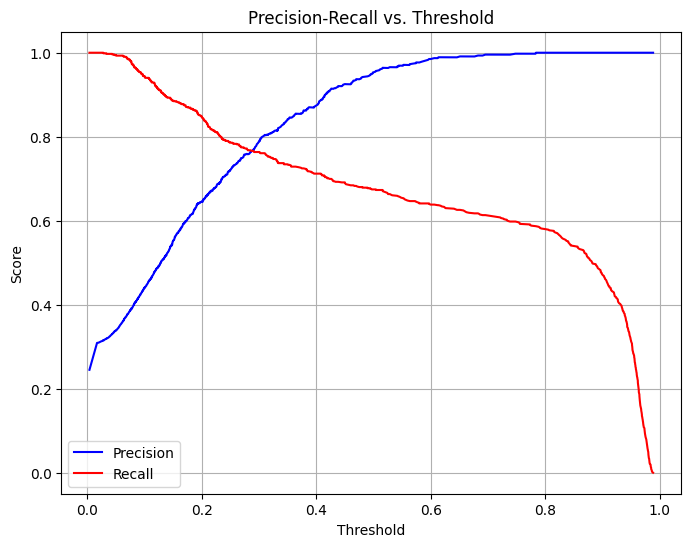

In [81]:
# plot the precision-recall vs threshold curve, to estimate what would be the best trade-off

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()


### Train Final Model on Full Dataset

In [77]:
# Train model with best parameters on full dataset
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    **best_params
)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7766526372748923, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01300377560176688,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=495, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Save Model

In [78]:
# Save the model
with open('models_and_preprocessing/model_prediction_complication.pkl', 'wb') as f:
    pickle.dump(final_model, f)